In [1]:
#load csv file into a pandas dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/detection_pipeline_results/detection_results_01.db')
c = conn.cursor()

## Results

In [4]:
# query sum of number of frames from all videos in database
c.execute('SELECT SUM(total_frames) FROM VideoStatistics')
total_frames = c.fetchone()[0]
total_frames

19023571

In [5]:
frames_with_detections_query = """
WITH FramesWithDetections AS (
    -- First get unique frames with detections for each class and video
    SELECT 
        v.id,
        v.video_id,
        d.frame_number,
        MAX(CASE WHEN d.object_class = 1.0 THEN 1 ELSE 0 END) as has_adult,
        MAX(CASE WHEN d.object_class = 0.0 THEN 1 ELSE 0 END) as has_child,
        MAX(CASE WHEN d.object_class = 3.0 THEN 1 ELSE 0 END) as has_adult_face,
        MAX(CASE WHEN d.object_class = 2.0 THEN 1 ELSE 0 END) as has_child_face,
        MAX(CASE WHEN d.object_class = 5.0 THEN 1 ELSE 0 END) as has_book,
        MAX(CASE WHEN d.object_class = 6.0 THEN 1 ELSE 0 END) as has_toy,
        MAX(CASE WHEN d.object_class = 7.0 THEN 1 ELSE 0 END) as has_kitchenware,
        MAX(CASE WHEN d.object_class = 8.0 THEN 1 ELSE 0 END) as has_screen,
        MAX(CASE WHEN d.object_class = 9.0 THEN 1 ELSE 0 END) as has_food,
        MAX(CASE WHEN d.object_class = 10.0 THEN 1 ELSE 0 END) as has_other_object
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    GROUP BY v.id, v.video_id, d.frame_number
),
TotalFramesPerChild AS (
    -- Calculate total frames per child ID
    SELECT 
        v.id,
        SUM(vs.total_frames) as total_frames
    FROM Videos v
    JOIN VideoStatistics vs ON v.video_id = vs.video_id
    GROUP BY v.id
)
-- Then aggregate detections by child ID
SELECT 
    f.id,
    COUNT(DISTINCT f.video_id) as video_count,
    t.total_frames,
    SUM(f.has_adult) as frames_with_adult,
    SUM(f.has_child) as frames_with_child,
    SUM(f.has_adult_face) as frames_with_adult_face,
    SUM(f.has_child_face) as frames_with_child_face,
    SUM(f.has_book) as frames_with_book,
    SUM(f.has_toy) as frames_with_toy,
    SUM(f.has_kitchenware) as frames_with_kitchenware,
    SUM(f.has_screen) as frames_with_screen,
    SUM(f.has_food) as frames_with_food,
    SUM(f.has_other_object) as frames_with_other_object
FROM FramesWithDetections f
JOIN TotalFramesPerChild t ON f.id = t.id
JOIN VideoStatistics vs ON f.video_id = vs.video_id
GROUP BY f.id, t.total_frames
ORDER BY f.id;
"""

# Execute query and create DataFrame
frames_with_detections = pd.read_sql(frames_with_detections_query, conn)


# Calculate percentages
for col in frames_with_detections.columns[3:]:  # Skip id, video_count, and total_frames
    frames_with_detections[f'{col}_percent'] = (
        frames_with_detections[col] / frames_with_detections['total_frames'] * 100
    ).round(2)

# Display results
display(frames_with_detections)

,id,video_count,total_frames,frames_with_adult,frames_with_child,frames_with_adult_face,frames_with_child_face,frames_with_book,frames_with_toy,frames_with_kitchenware,...,frames_with_adult_percent,frames_with_child_percent,frames_with_adult_face_percent,frames_with_child_face_percent,frames_with_book_percent,frames_with_toy_percent,frames_with_kitchenware_percent,frames_with_screen_percent,frames_with_food_percent,frames_with_other_object_percent
0,254922,8,363585,6731,4320,4534,1753,690,1508,106,...,1.85,1.19,1.25,0.48,0.19,0.41,0.03,0.00,0.00,0.46
1,255237,6,282993,5405,15208,1570,6359,1165,7373,50,...,1.91,5.37,0.55,2.25,0.41,2.61,0.02,0.02,0.12,1.05
2,255695,4,68763,2165,2357,780,1008,5,881,630,...,3.15,3.43,1.13,1.47,0.01,1.28,0.92,0.00,0.00,0.47
3,255706,2,72922,3693,2122,1178,1359,379,1557,458,...,5.06,2.91,1.62,1.86,0.52,2.14,0.63,0.00,0.00,0.25
4,255944,5,138006,3224,4767,849,2661,2067,1244,244,...,2.34,3.45,0.62,1.93,1.50,0.90,0.18,0.00,0.03,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,271611,7,286457,2972,2895,2210,232,1005,3994,471,...,1.04,1.01,0.77,0.08,0.35,1.39,0.16,0.01,0.06,0.96
70,271700,6,200637,9361,2115,5093,1233,736,1244,130,...,4.67,1.05,2.54,0.61,0.37,0.62,0.06,0.02,0.04,1.06
71,272475,4,171070,5154,1768,1888,868,1211,676,169,...,3.01,1.03,1.10,0.51,0.71,0.40,0.10,0.01,0.02,1.17
72,273855,6,303755,6960,1994,2302,656,588,1060,74,...,2.29,0.66,0.76,0.22,0.19,0.35,0.02,0.01,0.01,0.47


In [ ]:
developmental_trends_query = """
WITH FramesWithDetections AS (
    SELECT 
        v.id as id,
        v.age_at_recording,
        v.video_id,
        d.frame_number,
        -- Social interaction indicators
        MAX(CASE WHEN d.object_class = 1.0 THEN 1 ELSE 0 END) as has_adult,
        MAX(CASE WHEN d.object_class = 3.0 THEN 1 ELSE 0 END) as has_adult_face,
        -- Combined adult presence (body or face)
        MAX(CASE WHEN d.object_class IN (1.0, 3.0) THEN 1 ELSE 0 END) as has_adult_presence,
        -- Adult-child co-presence
        MAX(CASE 
            WHEN EXISTS (
                SELECT 1 
                FROM Detections d2 
                WHERE d2.video_id = d.video_id 
                AND d2.frame_number = d.frame_number 
                AND d2.object_class IN (0.0, 2.0)
            ) 
            AND d.object_class IN (1.0, 3.0) THEN 1 
            ELSE 0 
        END) as has_social_interaction
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    WHERE v.age_at_recording IS NOT NULL
    GROUP BY v.id, v.age_at_recording, v.video_id, d.frame_number
)
SELECT 
    id,
    age_at_recording,
    COUNT(DISTINCT video_id) as video_count,
    COUNT(DISTINCT frame_number) as total_frames,
    -- Social interaction metrics
    SUM(has_adult_presence) as frames_with_adult,
    SUM(has_social_interaction) as frames_with_interaction,
    -- Calculate percentages
    ROUND(SUM(has_adult_presence) * 100.0 / COUNT(DISTINCT frame_number), 2) as adult_presence_percent,
    ROUND(SUM(has_social_interaction) * 100.0 / COUNT(DISTINCT frame_number), 2) as interaction_percent
FROM FramesWithDetections
GROUP BY id, age_at_recording
ORDER BY age_at_recording;
"""

# Execute query and create DataFrame
developmental_trends = pd.read_sql(developmental_trends_query, conn)

# Create visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=developmental_trends, 
                x='age_at_recording', 
                y='interaction_percent',
                size='video_count',
                sizes=(50, 200),
                alpha=0.6)

plt.title('Age-Related Changes in Adult-Child Interaction')
plt.xlabel('Age at Recording (years)')
plt.ylabel('Percentage of Frames with Adult-Child Interaction')

# Add trend line
sns.regplot(data=developmental_trends,
            x='age_at_recording',
            y='interaction_percent',
            scatter=False,
            color='red')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Age (rounded to nearest year):")
developmental_trends['age_rounded'] = developmental_trends['age_at_recording'].round()
age_summary = developmental_trends.groupby('age_rounded').agg({
    'interaction_percent': ['mean', 'std', 'count'],
    'adult_presence_percent': ['mean', 'std']
}).round(2)
print(age_summary)

In [3]:
# Add age_at_recording column to Videos table
alter_table_query = """
ALTER TABLE Videos 
ADD COLUMN age_at_recording REAL;
"""

cursor = conn.cursor()
cursor.execute(alter_table_query)
conn.commit()

# Verify the column was added
verify_schema_query = """
PRAGMA table_info(Videos);
"""
print("Updated Videos table schema:")
print(pd.read_sql(verify_schema_query, conn))

OperationalError: duplicate column name: age_at_recording

#### Get adult presence vs. child presence over different age groups 

In [ ]:
developmental_trends_query = """
WITH FramesWithDetections AS (
    SELECT 
        v.id,
        v.age_at_recording,
        v.video_id,
        d.frame_number,
        -- Social interaction indicators
        MAX(CASE WHEN d.object_class = 1.0 THEN 1 ELSE 0 END) as has_adult,
        MAX(CASE WHEN d.object_class = 3.0 THEN 1 ELSE 0 END) as has_adult_face,
        -- Combined adult presence (body or face)
        MAX(CASE WHEN d.object_class IN (1.0, 3.0) THEN 1 ELSE 0 END) as has_adult_presence,
        -- Adult-child co-presence
        MAX(CASE 
            WHEN EXISTS (
                SELECT 1 
                FROM Detections d2 
                WHERE d2.video_id = d.video_id 
                AND d2.frame_number = d.frame_number 
                AND d2.object_class IN (0.0, 2.0)
            ) 
            AND d.object_class IN (1.0, 3.0) THEN 1 
            ELSE 0 
        END) as has_social_interaction
    FROM Videos v
    JOIN Detections d ON v.video_id = d.video_id
    WHERE v.age_at_recording IS NOT NULL
    GROUP BY v.id, v.age_at_recording, v.video_id, d.frame_number
)
SELECT 
    id,
    age_at_recording,
    COUNT(DISTINCT video_id) as video_count,
    COUNT(DISTINCT frame_number) as total_frames,
    -- Social interaction metrics
    SUM(has_adult_presence) as frames_with_adult,
    SUM(has_social_interaction) as frames_with_interaction,
    -- Calculate percentages
    ROUND(SUM(has_adult_presence) * 100.0 / COUNT(DISTINCT frame_number), 2) as adult_presence_percent,
    ROUND(SUM(has_social_interaction) * 100.0 / COUNT(DISTINCT frame_number), 2) as interaction_percent
FROM FramesWithDetections
GROUP BY id, age_at_recording
ORDER BY age_at_recording;
"""

# Execute query and create DataFrame
developmental_trends = pd.read_sql(developmental_trends_query, conn)

# Create visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=developmental_trends, 
                x='age_at_recording', 
                y='interaction_percent',
                size='video_count',
                sizes=(50, 200),
                alpha=0.6)

plt.title('Age-Related Changes in Adult-Child Interaction')
plt.xlabel('Age at Recording (years)')
plt.ylabel('Percentage of Frames with Adult-Child Interaction')

# Add trend line
sns.regplot(data=developmental_trends,
            x='age_at_recording',
            y='interaction_percent',
            scatter=False,
            color='red')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Age (rounded to nearest year):")
developmental_trends['age_rounded'] = developmental_trends['age_at_recording'].round()
age_summary = developmental_trends.groupby('age_rounded').agg({
    'interaction_percent': ['mean', 'std', 'count'],
    'adult_presence_percent': ['mean', 'std']
}).round(2)
print(age_summary)

#### Compare percentage of adult faces looking at child vs. child faces looking at child

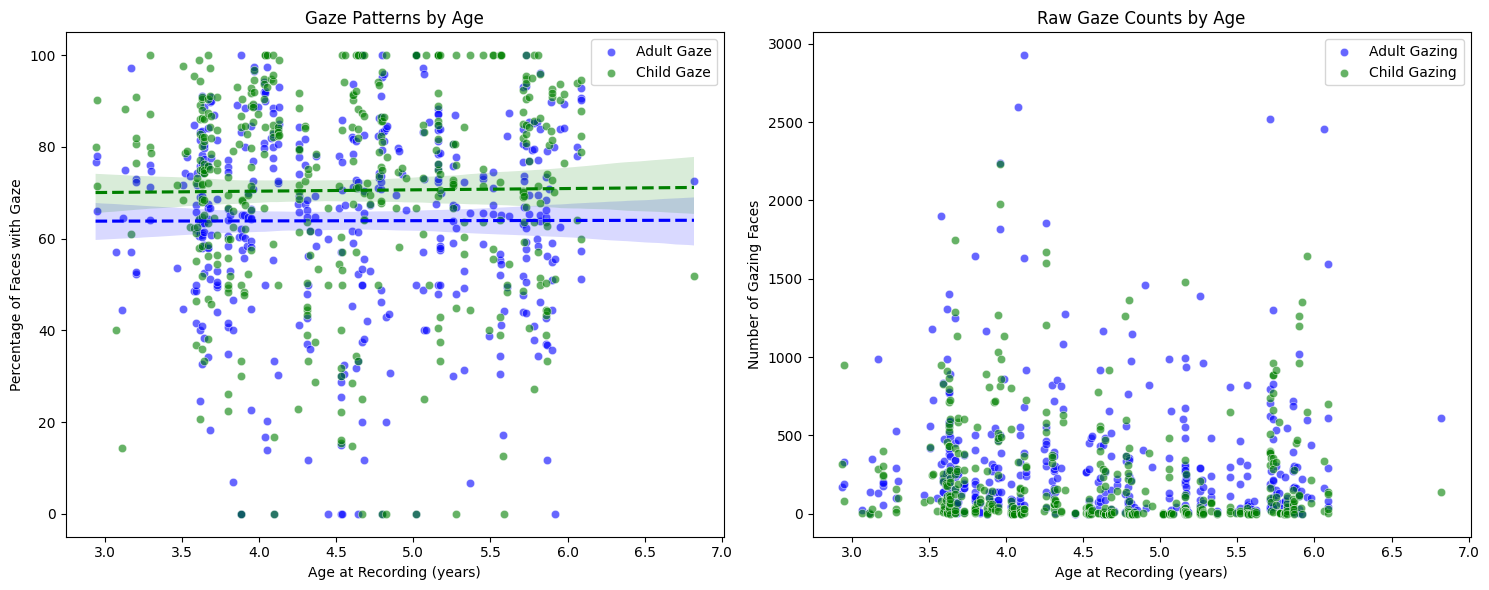


Gaze Pattern Summary by Age Group:
          adult_gaze_percent              child_gaze_percent               \
                        mean    std count               mean    std count   
age_group                                                                   
3.0                    67.02  12.67    18              74.58  21.15    16   
4.0                    64.11  20.93   183              70.37  20.34   182   
5.0                    63.31  24.09   140              69.25  25.95   126   
6.0                    63.69  19.84    89              72.24  21.95    83   
7.0                    72.60    NaN     1              51.91    NaN     1   

          total_adult_faces total_child_faces  
                        sum               sum  
age_group                                      
3.0                    6310              3989  
4.0                   98804             71757  
5.0                   48437             21347  
6.0                   39609             27222  
7.0        

In [ ]:
gaze_analysis_query = """
SELECT 
    v.id as id,
    v.age_at_recording,
    v.video_id,
    -- Adult gaze counts
    COUNT(CASE WHEN d.object_class = 3.0 THEN 1 END) as total_adult_faces,
    COUNT(CASE WHEN d.object_class = 3.0 AND d.gaze_direction = 1 THEN 1 END) as adult_gazing,
    -- Child gaze counts
    COUNT(CASE WHEN d.object_class = 2.0 THEN 1 END) as total_child_faces,
    COUNT(CASE WHEN d.object_class = 2.0 AND d.gaze_direction = 1 THEN 1 END) as child_gazing,
    -- Calculate percentages
    ROUND(COUNT(CASE WHEN d.object_class = 3.0 AND d.gaze_direction = 1.0 THEN 1 END) * 100.0 / 
          NULLIF(COUNT(CASE WHEN d.object_class = 3.0 THEN 1 END), 0), 2) as adult_gaze_percent,
    ROUND(COUNT(CASE WHEN d.object_class = 2.0 AND d.gaze_direction = 1 THEN 1 END) * 100.0 / 
          NULLIF(COUNT(CASE WHEN d.object_class = 2.0 THEN 1 END), 0), 2) as child_gaze_percent
FROM Videos v
JOIN Detections d ON v.video_id = d.video_id
WHERE v.age_at_recording IS NOT NULL
    AND d.object_class IN (2.0, 3.0)  -- Only look at face detections
GROUP BY v.id, v.age_at_recording, v.video_id
ORDER BY v.age_at_recording;
"""
# Execute query and create DataFrame
gaze_patterns = pd.read_sql(gaze_analysis_query, conn)

# Create age groups
def assign_age_group(age):
    if age < 4:
        return 3
    elif age < 5:
        return 4
    elif age < 6:
        return 5
    else:
        return 6

# Apply age grouping
gaze_patterns['age_group'] = gaze_patterns['age_at_recording'].apply(assign_age_group)

# Calculate summary statistics with new age groups
summary_stats = gaze_patterns.groupby('age_group').agg({
    'adult_gaze_percent': ['mean', 'std', 'count'],
    'child_gaze_percent': ['mean', 'std', 'count'],
    'total_adult_faces': 'sum',
    'total_child_faces': 'sum'
}).round(2)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Adult gaze percentages
adult_scatter = sns.scatterplot(data=gaze_patterns, 
                x='age_at_recording', 
                y='adult_gaze_percent',
                color='blue',
                alpha=0.6,
                ax=ax1)

# Plot 1: Child gaze percentages
child_scatter = sns.scatterplot(data=gaze_patterns, 
                x='age_at_recording', 
                y='child_gaze_percent',
                color='green',
                alpha=0.6,
                ax=ax1)

# Add trend lines
adult_trend = sns.regplot(data=gaze_patterns,
            x='age_at_recording',
            y='adult_gaze_percent',
            scatter=False,
            color='blue',
            line_kws={'linestyle': '--'},
            ax=ax1)

child_trend = sns.regplot(data=gaze_patterns,
            x='age_at_recording',
            y='child_gaze_percent',
            scatter=False,
            color='green',
            line_kws={'linestyle': '--'},
            ax=ax1)

# Manually set legend for first plot
ax1.legend(['Adult Gaze', 'Child Gaze'])
ax1.set_title('Gaze Patterns by Age')
ax1.set_xlabel('Age at Recording (years)')
ax1.set_ylabel('Percentage of Faces with Gaze')

# Plot 2: Raw counts (adult)
sns.scatterplot(data=gaze_patterns, 
                x='age_at_recording', 
                y='adult_gazing',
                color='blue',
                alpha=0.6,
                ax=ax2)

# Plot 2: Raw counts (child)
sns.scatterplot(data=gaze_patterns, 
                x='age_at_recording', 
                y='child_gazing',
                color='green',
                alpha=0.6,
                ax=ax2)

# Manually set legend for second plot
ax2.legend(['Adult Gazing', 'Child Gazing'])
ax2.set_title('Raw Gaze Counts by Age')
ax2.set_xlabel('Age at Recording (years)')
ax2.set_ylabel('Number of Gazing Faces')

plt.tight_layout()
plt.show()

# Print summary statistics grouped by age (rounded to nearest year)
print("\nGaze Pattern Summary by Age Group:")
gaze_patterns['age_group'] = gaze_patterns['age_at_recording'].round()
summary_stats = gaze_patterns.groupby('age_group').agg({
    'adult_gaze_percent': ['mean', 'std', 'count'],
    'child_gaze_percent': ['mean', 'std', 'count'],
    'total_adult_faces': 'sum',
    'total_child_faces': 'sum'
}).round(2)

print("\nGaze Pattern Summary by Age Group:")
print(summary_stats)

In [12]:
# Find the row where age_at_recording is approximately 7
outlier = gaze_patterns[gaze_patterns['age_at_recording'] >= 7]
print("Details of outlier recording(s):")
print(outlier.to_string(index=False))

# Get the video details from the database
outlier_query = """
SELECT 
    v.*,
    s.birthday
FROM Videos v
LEFT JOIN Subjects s ON v.id = s.ID
WHERE v.age_at_recording >= 7;
"""
outlier_details = pd.read_sql(outlier_query, conn)
print("\nVideo details from database:")
print(outlier_details.to_string(index=False))

Details of outlier recording(s):
Empty DataFrame
Columns: [id, age_at_recording, video_id, total_adult_faces, adult_gazing, total_child_faces, child_gazing, adult_gaze_percent, child_gaze_percent, age_group]
Index: []

Video details from database:
Empty DataFrame
Columns: [video_id, video_path, id, recording_date, age_at_recording, birthday]
Index: []


In [49]:
# save frames_with_detections and video_birthdays to the same csv file
frames_with_detections.to_csv('/home/nele_pauline_suffo/outputs/detection_pipeline_results/frames_with_detections.csv', index=False)
video_birthdays.to_csv('/home/nele_pauline_suffo/outputs/detection_pipeline_results/video_birthdays.csv', index=False)

## Plotting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

# First, get raw data with proper summed normalization
raw_data_query = """
SELECT 
    age_group,
    video_id,
    CAST(child_count AS FLOAT) / total_frames as norm_child_count,
    CAST(adult_count AS FLOAT) / total_frames as norm_adult_count,
    CAST(child_face_count AS FLOAT) / total_frames as norm_child_face_count,
    CAST(adult_face_count AS FLOAT) / total_frames as norm_adult_face_count,
    CAST(toy_count AS FLOAT) / total_frames as norm_toy_count,
    CAST(book_count AS FLOAT) / total_frames as norm_book_count,
    CAST(kitchenware_count AS FLOAT) / total_frames as norm_kitchenware_count,
    CAST(screen_count AS FLOAT) / total_frames as norm_screen_count,
    CAST(other_object_count AS FLOAT) / total_frames as norm_other_object_count
FROM VideoStatistics
WHERE age_group IS NOT NULL;
"""

raw_data = pd.read_sql(raw_data_query, conn)

# Define classes and display names
classes = ['norm_child_count', 'norm_adult_count', 'norm_child_face_count',
           'norm_adult_face_count', 'norm_toy_count', 'norm_book_count',
           'norm_kitchenware_count', 'norm_screen_count', 'norm_other_object_count']

class_display_names = {
    'norm_child_count': 'Child',
    'norm_adult_count': 'Adult',
    'norm_child_face_count': 'Child Face',
    'norm_adult_face_count': 'Adult Face',
    'norm_toy_count': 'Toy',
    'norm_book_count': 'Book',
    'norm_kitchenware_count': 'Kitchenware',
    'norm_screen_count': 'Screen',
    'norm_other_object_count': 'Other Objects'
}

# Perform Kruskal-Wallis tests and track significant classes
test_results = []
significant_classes = []

for class_name in classes:
    groups = [group[class_name].values 
             for name, group in raw_data.groupby('age_group')]
    h_stat, p_val = stats.kruskal(*groups)
    
    test_results.append({
        'class_name': class_name,
        'display_name': class_display_names[class_name],
        'h_statistic': h_stat,
        'p_value': p_val
    })
    
    if p_val < 0.05:
        significant_classes.append(class_name)

significance_results = pd.DataFrame(test_results)

# Perform pairwise tests only for significant classes with Bonferroni correction
def perform_pairwise_tests(data, class_name, display_name):
    age_groups = sorted(data['age_group'].unique())
    results = []
    
    for i in range(len(age_groups)):
        for j in range(i+1, len(age_groups)):  
            group1 = data[data['age_group'] == age_groups[i]][class_name]
            group2 = data[data['age_group'] == age_groups[j]][class_name]
            
            stat, pval = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            
            results.append({
                'Class': display_name,
                'Group 1': age_groups[i],
                'Group 2': age_groups[j],
                'Statistic': stat,
                'p-value': pval
            })
    
    return results

# Collect and correct pairwise results
all_pairwise_results = []
for class_name in significant_classes:
    display_name = class_display_names[class_name]
    results = perform_pairwise_tests(raw_data, class_name, display_name)
    all_pairwise_results.extend(results)

pairwise_results_df = pd.DataFrame(all_pairwise_results)

# Apply Bonferroni correction
pairwise_results_df['p_adjusted'] = multipletests(
    pairwise_results_df['p-value'], method='bonferroni'
)[1]

# Add significance labels
pairwise_results_df['Significance'] = np.where(
    pairwise_results_df['p_adjusted'] < 0.001, '***',
    np.where(pairwise_results_df['p_adjusted'] < 0.01, '**',
    np.where(pairwise_results_df['p_adjusted'] < 0.05, '*', 'ns'))
)

# Prepare melted data for plotting
normalized_results_melted = pd.melt(
    raw_data,
    id_vars=['age_group'],
    value_vars=[c for c in classes],
    var_name='class',
    value_name='normalized_count'
)
normalized_results_melted['display_name'] = normalized_results_melted['class'].map(class_display_names)

# Create annotation dictionary from significant pairwise results
sig_pairwise = pairwise_results_df[pairwise_results_df['Significance'] != 'ns']
annotation_dict = {}
for _, row in sig_pairwise.iterrows():
    key = (row['Class'], row['Group 1'], row['Group 2'])
    annotation_dict[key] = row['Significance']

# Define custom colors for age groups
age_group_colors = {
    3: '#8D8E3D',  # leuphana green
    4: '#691633',  # leuphana red
    5: '#B3B6B0',  # leuphana blue
}
# Create visualization with significance bars
plt.figure(figsize=(18, 10))
ax = sns.barplot(
    x='display_name',
    y='normalized_count',
    hue='age_group',
    data=normalized_results_melted,
    order=class_display_names.values(),
    palette=age_group_colors
)

# Set fixed y-axis limit to 0.04
y_max_fixed = 0.055
ax.set_ylim(0, y_max_fixed)

# Define class-specific base heights
class_base_heights = {
    'Child': 0.045,         
    'Adult': 0.04,         
    'Child Face': 0.012,   
    'Adult Face': 0.04,    
    'Toy': 0.013,          
    'Book': 0.008,         
    'Kitchenware': 0.003,  
    'Screen': 0.04,      
    'Other Objects': 0.04
}

# Define spacing parameters
bracket_step = 0.0015  # Space between stacked brackets

# Track current height for each class to avoid overlaps
class_heights = {class_name: base_height for class_name, base_height in class_base_heights.items()}

# Get x positions for each category
x_positions = np.arange(len(class_display_names))
bar_width = 0.8 / len(raw_data['age_group'].unique())

# Loop through significant comparisons and draw brackets
for i, class_name in enumerate(class_display_names.values()):
    for j in range(len(age_groups)):
        for k in range(j+1, len(age_groups)):
            group1 = age_groups[j]
            group2 = age_groups[k]
            
            if (class_name, group1, group2) in annotation_dict:
                significance = annotation_dict[(class_name, group1, group2)]
                
                # Calculate x positions for bars
                x_pos1 = x_positions[i] + (j - len(age_groups)/2 + 0.5) * bar_width
                x_pos2 = x_positions[i] + (k - len(age_groups)/2 + 0.5) * bar_width
                
                # Get the current height for this class and increment for next
                y_pos = class_heights[class_name]
                class_heights[class_name] += bracket_step
                
                # Draw the bracket
                ax.plot([x_pos1, x_pos1, x_pos2, x_pos2], 
                        [y_pos, y_pos + bracket_step * 0.3, y_pos + bracket_step * 0.3, y_pos], 
                        color='black', linewidth=1)
                
                # Add the significance label
                ax.text((x_pos1 + x_pos2) / 2, y_pos + bracket_step * 0.2, significance, 
                       ha='center', va='bottom')

total_videos = len(raw_data['video_id'].unique())
total_frames_query = """
SELECT SUM(total_frames) as total_frames
FROM VideoStatistics
WHERE age_group IS NOT NULL;
"""
total_frames = pd.read_sql(total_frames_query, conn).iloc[0]['total_frames']

plt.title(f'Comparison of YOLO11x Object Detection Classes Across Age Groups\n(Normalized Counts per Frame)\n'
          f'Applied on Quantex Dataset: {total_videos:,} Videos, {total_frames:,} Frames')
plt.xlabel('')  # Remove x-axis label
plt.ylabel('Normalized Counts (Objects per Frame)')
plt.xticks(rotation=45)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/outputs/detection_pipeline_results/quantex_normalized_counts.png')

plt.show()
# save the figure

# Display filtered results
print("## Significant Kruskal-Wallis Results (p < 0.05) ##")
display(significance_results[significance_results['p_value'] < 0.05]
        [['display_name', 'h_statistic', 'p_value']].round(4))

print("\nRaw Pairwise Comparisons:")
# display full p-values for as 0.0000
pd.options.display.float_format = '{:.4f}'.format
display(pairwise_results_df[['Class', 'Group 1', 'Group 2', 'p-value']])

print("\n## Significant Pairwise Comparisons (Bonferroni-corrected) ##")
display(sig_pairwise[['Class', 'Group 1', 'Group 2', 
                     'Statistic', 'p_adjusted', 'Significance']].round(4))


In [ ]:
# Close connection
conn.close()